In [13]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as cmnorm
from matplotlib.colors import LogNorm
import numpy as np
import glob, os
from mpl_toolkits.mplot3d import Axes3D
import gsw
import xarray as xr
import math
from scipy.interpolate import RegularGridInterpolator as rgi
from scipy.interpolate import griddata
from scipy.interpolate import LinearNDInterpolator
import pickle
import cmocean
import string
%matplotlib inline
plt.rcParams.update({'font.size':20})

### Particle figures
Processed particle trajectories are found at: 10.6084/m9.figshare.13322555

In [2]:
f = open("particles_with_gradients.pkl","rb")
dfdict = pickle.load(f)
f.close()

/vortexfs1/home/mfreilich/.conda/envs/particles3/lib/python3.7/site-packages/matplotlib/contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


18740


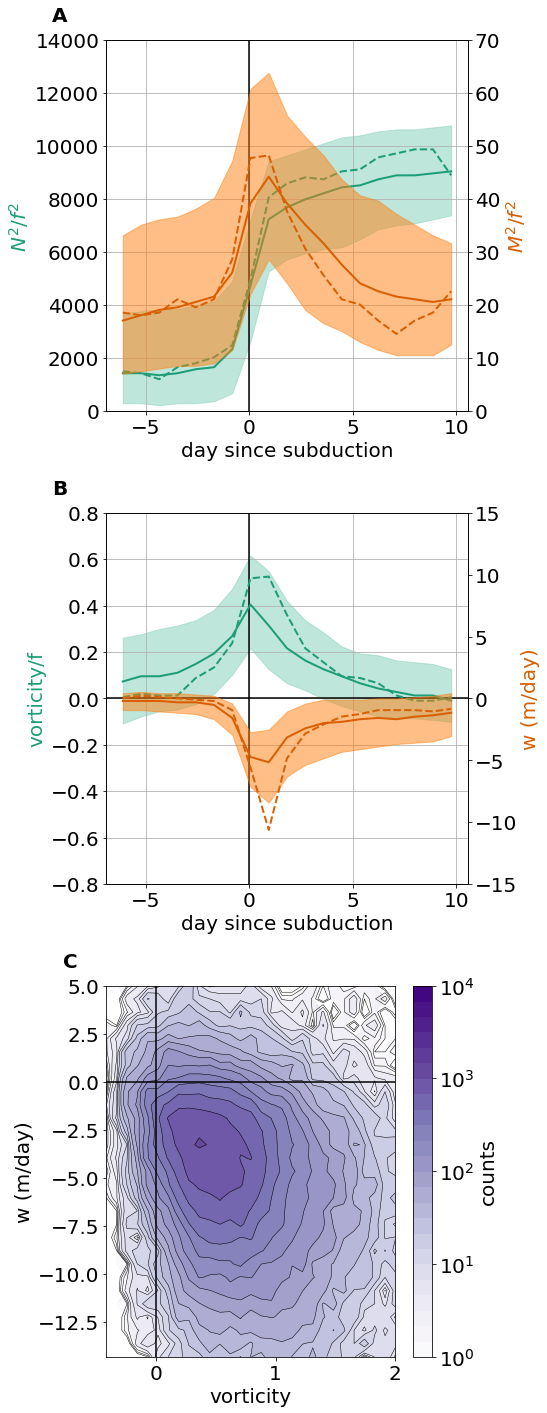

In [14]:
d = 44
g = 9.81
f = 1e-4
R0 = 1027
df1 = dfdict['df'+str(d)]
df1vor2 = dfdict['df'+str(d)+'vor2']
df1vor3 = dfdict['df'+str(d)+'vor3']
df1rx = dfdict['df'+str(d)+'rx']
df1ry = dfdict['df'+str(d)+'ry']
df1rz = dfdict['df'+str(d)+'rz']
time1 = dfdict['time'+str(d)]

idx = time1.columns[np.min(df1['w'].loc[:,time1.columns]*86400) < -20]
time1 = time1.loc[:,idx]

hor = -df1vor2*df1rx*g/R0-df1vor3*df1ry*g/R0
vert = (f+df1['vorticity'])*-df1rz*g/R0
M2 = ((df1rx*g/R0)**2+(df1ry*g/R0)**2)**(1/2)

H0, xedges0, yedges0 = np.histogram2d(time1.values.flatten(),
                                      -g/R0*df1rz.loc[:,idx].values.flatten()/(f**2),
                                      bins = [np.linspace(-7,9.75,20),np.linspace(0,0.00015/(f**2),200)])
H1, xedges1, yedges1 = np.histogram2d(time1.values.flatten(),
                                      df1['vorticity'].loc[:,idx].values.flatten()/f,
                                      bins = [np.linspace(-7,9.75,20),np.linspace(-0.5,1,200)])
H2, xedges2, yedges2 = np.histogram2d(time1.values.flatten(),
                                      vert.loc[:,idx].values.flatten(),
                                      bins = [np.linspace(-7,9.75,20),np.linspace(0,2e-8,1000)])
H3, xedges3, yedges3 = np.histogram2d(time1.values.flatten(),
                                      hor.loc[:,idx].values.flatten(),
                                      bins = [np.linspace(-7,9.75,20),np.linspace(-5e-8,1e-9,300)])
H4, xedges4, yedges4 = np.histogram2d(time1.values.flatten(),
                                      M2.loc[:,idx].values.flatten()/(f**2),
                                      bins = [np.linspace(-7,9.75,20),np.linspace(0,100,200)])
H5, xedges5, yedges5 = np.histogram2d(time1.values.flatten(),
                                      df1['w'].loc[:,idx].values.flatten()*86400,
                                      bins = [np.linspace(-7,9.75,20),np.linspace(-40,2,400)])
particount = time1.shape[1]
for d in np.arange(45,62):
    df1 = dfdict['df'+str(d)]
    df1vor2 = dfdict['df'+str(d)+'vor2']
    df1vor3 = dfdict['df'+str(d)+'vor3']
    df1rx = dfdict['df'+str(d)+'rx']
    df1ry = dfdict['df'+str(d)+'ry']
    df1rz = dfdict['df'+str(d)+'rz']
    time1 = dfdict['time'+str(d)]
    
    idx = time1.columns[np.min(df1['w'].loc[:,time1.columns]*86400) < -20]
    time1 = time1.loc[:,idx]
    
    hor = -df1vor2*df1rx*g/R0-df1vor3*df1ry*g/R0
    vert = (f+df1['vorticity'])*-df1rz*g/R0
    M2 = ((df1rx*g/R0)**2+(df1ry*g/R0)**2)**(1/2)
    
    H, xedges0, yedges0 = np.histogram2d(time1.values.flatten(),
                                          -g/R0*df1rz.loc[:,idx].values.flatten()/(f**2),
                                          bins = [np.linspace(-7,9.75,20),np.linspace(0,0.00015/(f**2),200)])
    H0 = H0+H
    H, xedges1, yedges1 = np.histogram2d(time1.values.flatten(),
                                          df1['vorticity'].loc[:,idx].values.flatten()/f,
                                          bins = [np.linspace(-7,9.75,20),np.linspace(-0.5,1,200)])
    H1 = H1+H
    H, xedges2, yedges2 = np.histogram2d(time1.values.flatten(),
                                          vert.loc[:,idx].values.flatten(),
                                          bins = [np.linspace(-7,9.75,20),np.linspace(0,2e-8,1000)])
    H2 = H2+H
    H, xedges3, yedges3 = np.histogram2d(time1.values.flatten(),
                                          hor.loc[:,idx].values.flatten(),
                                          bins = [np.linspace(-7,9.75,20),np.linspace(-5e-8,1e-9,300)])
    H3 = H3+H
    H, xedges4, yedges4 = np.histogram2d(time1.values.flatten(),
                                          M2.loc[:,idx].values.flatten()/(f**2),
                                          bins = [np.linspace(-7,9.75,20),np.linspace(0,100,200)])
    H4 = H4+H
    H, xedges5, yedges5 = np.histogram2d(time1.values.flatten(),
                                          df1['w'].loc[:,idx].values.flatten()*86400,
                                          bins = [np.linspace(-7,9.75,20),np.linspace(-40,2,400)])
    H5 = H5+H
    particount += time1.shape[1]

H_norm_rows = (H0.T/np.sum(H0,axis=1))
Hmasked = np.ma.masked_where(H_norm_rows==0,H_norm_rows) # Mask pixels with a value of zero
cdf = np.cumsum(H_norm_rows,axis = 0) # for calculating quantiles
H0med = yedges0[np.argmax(cdf > 0.5,axis = 0)]

H_norm_rows = (H4.T/np.sum(H4,axis=1))
Hmasked = np.ma.masked_where(H_norm_rows==0,H_norm_rows) # Mask pixels with a value of zero
cdf = np.cumsum(H_norm_rows,axis = 0) # for calculating quantiles
H4med = yedges4[np.argmax(cdf > 0.5,axis = 0)]

H_norm_rows = (H2.T/np.sum(H2,axis=1))
Hmasked = np.ma.masked_where(H_norm_rows==0,H_norm_rows) # Mask pixels with a value of zero
cdf = np.cumsum(H_norm_rows,axis = 0) # for calculating quantiles
H2med = yedges2[np.argmax(cdf > 0.5,axis = 0)]

H_norm_rows = (H3.T/np.sum(H3,axis=1))
Hmasked = np.ma.masked_where(H_norm_rows==0,H_norm_rows) # Mask pixels with a value of zero
cdf = np.cumsum(H_norm_rows,axis = 0) # for calculating quantiles
H3med = yedges3[np.argmax(cdf > 0.5,axis = 0)]

H_norm_rows = (H1.T/np.sum(H1,axis=1))
Hmasked = np.ma.masked_where(H_norm_rows==0,H_norm_rows) # Mask pixels with a value of zero
cdf = np.cumsum(H_norm_rows,axis = 0) # for calculating quantiles
H1med = yedges1[np.argmax(cdf > 0.5,axis = 0)]

H_norm_rows = (H5.T/np.sum(H5,axis=1))
Hmasked = np.ma.masked_where(H_norm_rows==0,H_norm_rows) # Mask pixels with a value of zero
cdf = np.cumsum(H_norm_rows,axis = 0) # for calculating quantiles
H5med = yedges5[np.argmax(cdf > 0.5,axis = 0)]

d = 44
g = 9.81
f = 1e-4
R0 = 1027
df1 = dfdict['df'+str(d)]
df1vor2 = dfdict['df'+str(d)+'vor2']
df1vor3 = dfdict['df'+str(d)+'vor3']
df1rx = dfdict['df'+str(d)+'rx']
df1ry = dfdict['df'+str(d)+'ry']
df1rz = dfdict['df'+str(d)+'rz']
time1 = dfdict['time'+str(d)]

idx = time1.columns
#time1 = time1.loc[:,idx]

hor = -df1vor2*df1rx*g/R0-df1vor3*df1ry*g/R0
vert = (f+df1['vorticity'])*-df1rz*g/R0
M2 = ((df1rx*g/R0)**2+(df1ry*g/R0)**2)**(1/2)

H0, xedges0, yedges0 = np.histogram2d(time1.values.flatten(),
                                      -g/R0*df1rz.loc[:,idx].values.flatten()/(f**2),
                                      bins = [np.linspace(-7,9.75,20),np.linspace(0,0.00015/(f**2),200)])
H1, xedges1, yedges1 = np.histogram2d(time1.values.flatten(),
                                      df1['vorticity'].loc[:,idx].values.flatten()/f,
                                      bins = [np.linspace(-7,9.75,20),np.linspace(-0.5,1,200)])
H2, xedges2, yedges2 = np.histogram2d(time1.values.flatten(),
                                      vert.loc[:,idx].values.flatten(),
                                      bins = [np.linspace(-7,9.75,20),np.linspace(0,2e-8,1000)])
H3, xedges3, yedges3 = np.histogram2d(time1.values.flatten(),
                                      hor.loc[:,idx].values.flatten(),
                                      bins = [np.linspace(-7,9.75,20),np.linspace(-5e-8,1e-9,300)])
H4, xedges4, yedges4 = np.histogram2d(time1.values.flatten(),
                                      M2.loc[:,idx].values.flatten()/(f**2),
                                      bins = [np.linspace(-7,9.75,20),np.linspace(0,100,200)])
H5, xedges5, yedges5 = np.histogram2d(time1.values.flatten(),
                                      df1['w'].loc[:,idx].values.flatten()*86400,
                                      bins = [np.linspace(-7,9.75,20),np.linspace(-40,2,400)])
H6, xedges6, yedges6 = np.histogram2d(time1.values.flatten(),
                                      df1['PV'].loc[:,idx].values.flatten(),
                                      bins = [np.linspace(-7,9.75,20),np.linspace(0,2e-8,1000)])

particount = time1.shape[1]
for d in np.arange(45,62):
    df1 = dfdict['df'+str(d)]
    df1vor2 = dfdict['df'+str(d)+'vor2']
    df1vor3 = dfdict['df'+str(d)+'vor3']
    df1rx = dfdict['df'+str(d)+'rx']
    df1ry = dfdict['df'+str(d)+'ry']
    df1rz = dfdict['df'+str(d)+'rz']
    time1 = dfdict['time'+str(d)]
    
    idx = time1.columns
    #time1 = time1.loc[:,idx]
    
    hor = -df1vor2*df1rx*g/R0-df1vor3*df1ry*g/R0
    vert = (f+df1['vorticity'])*-df1rz*g/R0
    M2 = ((df1rx*g/R0)**2+(df1ry*g/R0)**2)**(1/2)
    
    H, xedges0, yedges0 = np.histogram2d(time1.values.flatten(),
                                          -g/R0*df1rz.loc[:,idx].values.flatten()/(f**2),
                                          bins = [np.linspace(-7,9.75,20),np.linspace(0,0.00015/(f**2),200)])
    H0 = H0+H
    H, xedges1, yedges1 = np.histogram2d(time1.values.flatten(),
                                          df1['vorticity'].loc[:,idx].values.flatten()/f,
                                          bins = [np.linspace(-7,9.75,20),np.linspace(-0.5,1,200)])
    H1 = H1+H
    H, xedges2, yedges2 = np.histogram2d(time1.values.flatten(),
                                          vert.loc[:,idx].values.flatten(),
                                          bins = [np.linspace(-7,9.75,20),np.linspace(0,2e-8,1000)])
    H2 = H2+H
    H, xedges3, yedges3 = np.histogram2d(time1.values.flatten(),
                                          hor.loc[:,idx].values.flatten(),
                                          bins = [np.linspace(-7,9.75,20),np.linspace(-5e-8,1e-9,300)])
    H3 = H3+H
    H, xedges4, yedges4 = np.histogram2d(time1.values.flatten(),
                                          M2.loc[:,idx].values.flatten()/(f**2),
                                          bins = [np.linspace(-7,9.75,20),np.linspace(0,100,200)])
    H4 = H4+H
    H, xedges5, yedges5 = np.histogram2d(time1.values.flatten(),
                                          df1['w'].loc[:,idx].values.flatten()*86400,
                                          bins = [np.linspace(-7,9.75,20),np.linspace(-40,2,400)])
    H5 = H5+H
    H, xedges6, yedges6 = np.histogram2d(time1.values.flatten(),
                                          df1['PV'].loc[:,idx].values.flatten(),
                                          bins = [np.linspace(-7,9.75,20),np.linspace(0,2e-8,1000)])
    H6 = H6+H
    particount += time1.shape[1]

fig, axs = plt.subplots(3,1,figsize = (8,20))
ax = axs[0]
ax.plot((0,0),(0,14000),c='black')
H_norm_rows = (H0.T/np.sum(H0,axis=1))
Hmasked = np.ma.masked_where(H_norm_rows==0,H_norm_rows) # Mask pixels with a value of zero
cdf = np.cumsum(H_norm_rows,axis = 0) # for calculating quantiles
ax.plot(xedges0[1:],yedges0[np.argmax(cdf > 0.5,axis = 0)],c='#1b9e77',linewidth = 2)
ax.fill_between(xedges0[1:],yedges0[np.argmax(cdf > 0.25,axis = 0)],
                yedges0[np.argmax(cdf > 0.75,axis = 0)],alpha = 0.5,color = '#80cfb7')
ax.plot(xedges0[1:],H0med,c='#1b9e77',linewidth = 2,linestyle = '--')
ax.set_xlabel('day since subduction')
ax.set_ylabel('$N^2/f^2$',color = '#1b9e77')
ax.grid(True)
ax.text(-0.15, 1.05, 'A', transform=ax.transAxes,size=20, weight='bold')
ax1 = ax.twinx()

H_norm_rows = (H4.T/np.sum(H4,axis=1))
Hmasked = np.ma.masked_where(H_norm_rows==0,H_norm_rows) # Mask pixels with a value of zero
cdf = np.cumsum(H_norm_rows,axis = 0) # for calculating quantiles
ax1.plot(xedges4[1:],yedges4[np.argmax(cdf > 0.5,axis = 0)],c='#d95f02',linewidth = 2)
ax1.fill_between(xedges4[1:],yedges4[np.argmax(cdf > 0.25,axis = 0)],
                 yedges4[np.argmax(cdf > 0.75,axis = 0)],color = 'tab:orange',alpha = 0.5)
ax1.plot(xedges4[1:],H4med,c='#d95f02',linewidth = 2,linestyle = '--')
ax1.set_ylabel('$M^2/f^2$', color='#d95f02')
#ax1.set_yticks([-0.2,0,0.2,0.4,0.6,0.8])
ax1.yaxis.label.set_color('#d95f02')
ax1.set_ylim((0,70))
ax.set_ylim((0,14000))

x1 = ax.get_xlim()

ax = axs[1]
ax.plot((0,0),(-0.8,0.8),c='black')
ax.plot(x1,(0,0),c='black')
H_norm_rows = (H1.T/np.sum(H1,axis=1))
Hmasked = np.ma.masked_where(H_norm_rows==0,H_norm_rows) # Mask pixels with a value of zero
cdf = np.cumsum(H_norm_rows,axis = 0) # for calculating quantiles
ax.plot(xedges1[1:],yedges1[np.argmax(cdf > 0.5,axis = 0)],c='#1b9e77',linewidth = 2)
ax.fill_between(xedges1[1:],yedges1[np.argmax(cdf > 0.25,axis = 0)],
                yedges1[np.argmax(cdf > 0.75,axis = 0)],alpha = 0.5,color = '#80cfb7')
ax.plot(xedges1[1:],H1med,c='#1b9e77',linewidth = 2,linestyle = '--')
ax.set_xlabel('day since subduction')
ax.set_ylabel('vorticity/f',color = '#1b9e77')
ax.grid(True)
ax.text(-0.15, 1.05, 'B', transform=ax.transAxes,size=20, weight='bold')
ax.set_xlim(x1)
ax1 = ax.twinx()

H_norm_rows = (H5.T/np.sum(H5,axis=1))
Hmasked = np.ma.masked_where(H_norm_rows==0,H_norm_rows) # Mask pixels with a value of zero
cdf = np.cumsum(H_norm_rows,axis = 0) # for calculating quantiles
ax1.plot(xedges5[1:],yedges5[np.argmax(cdf > 0.5,axis = 0)],c='#d95f02',linewidth = 2)
ax1.fill_between(xedges5[1:],yedges5[np.argmax(cdf > 0.25,axis = 0)],
                 yedges5[np.argmax(cdf > 0.75,axis = 0)],color = 'tab:orange',alpha = 0.5)
ax1.plot(xedges5[1:],H5med,c='#d95f02',linewidth = 2,linestyle = '--')
ax1.set_ylabel('w (m/day)', color='#d95f02')
#ax1.set_yticks([-0.2,0,0.2,0.4,0.6,0.8])
ax1.yaxis.label.set_color('#d95f02')
ax1.set_ylim((-15,15))
ax.set_ylim((-0.8,0.8))

ax = axs[2]
W = np.empty(0)
V = np.empty(0)
f = gsw.f(36.5)
for d in np.arange(44,61):
    df1 = dfdict['df'+str(d)]
    time1 = dfdict['time'+str(d)]
    down = time1 == 0
    w1 = df1['w'].loc[:,time1.columns]
    vor1 = df1['vorticity'].loc[:,time1.columns]
    for i in np.arange(w1.shape[1]):
        idx = time1.index[down.iloc[:,i]]
        idx = np.where(w1.index == idx[0])[0] # find index
        W = np.append(W,w1.iloc[np.arange((idx-5),idx+1),i])
        V = np.append(V,vor1.iloc[np.arange((idx-5),idx+1),i])

H, xedges, yedges = np.histogram2d(W*86400,V/f,bins = [np.linspace(-15,5,30),np.linspace(-0.5,2,30)])

h = ax.contourf(yedges[1:],xedges[1:],H,cmap = 'Purples',norm=cmnorm.LogNorm(),levels = np.logspace(0,4,25))
ax.contour(yedges[1:],xedges[1:],H,colors = 'black',linewidths = 0.5,levels = np.logspace(0,4,25))
ax.plot(yedges[1:],0*yedges[1:],color = '#000000')
ax.plot(0*xedges[1:],xedges[1:],color = '#000000')
ax.set_ylabel('w (m/day)')
ax.set_xlabel('vorticity')
plt.colorbar(h,ax = ax,label = 'counts',ticks = [1e0,1e1,1e2,1e3,1e4])
ax.text(-0.15, 1.05, 'C', transform=ax.transAxes,size=20, weight='bold')

print(particount)
fig.tight_layout()
fig.savefig('fig5new_vert.pdf')

18740
18740


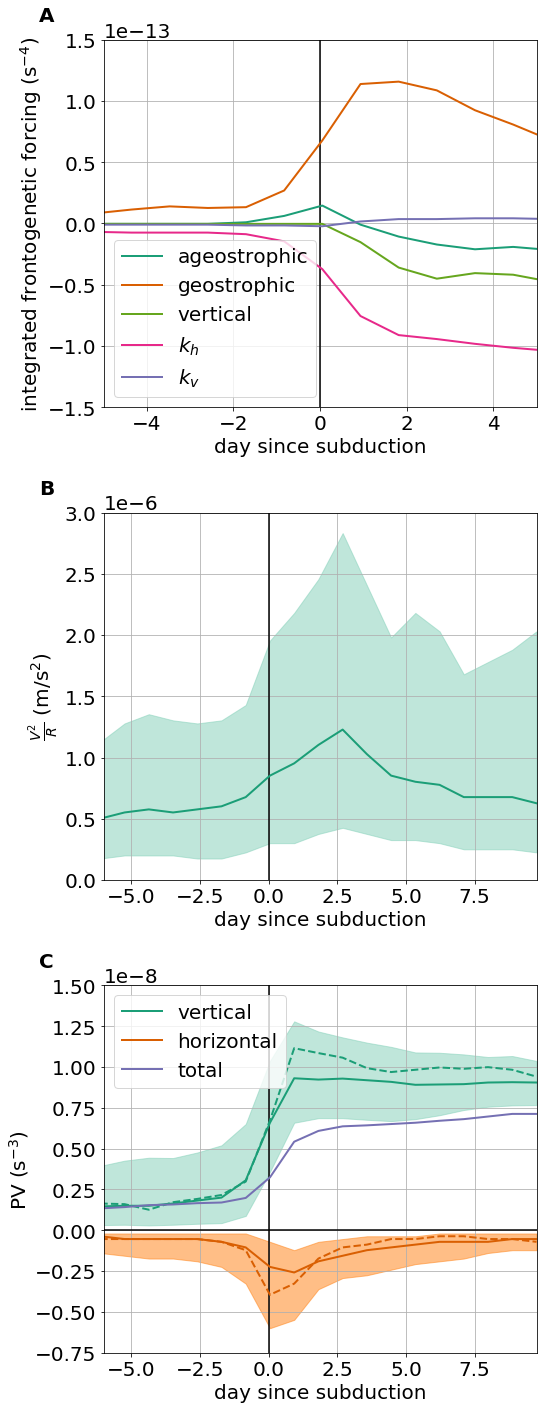

In [18]:
d = 44
g = 9.81
f = 1e-4
R0 = 1027
df1 = dfdict['df'+str(d)]
df1Q1 = dfdict['df'+str(d)+'Q1']
df1Q2 = dfdict['df'+str(d)+'Q2']
df1Qg1 = dfdict['df'+str(d)+'Qg1']
df1Qg2 = dfdict['df'+str(d)+'Qg2']
df1Qw = dfdict['df'+str(d)+'Qw']
df1Qkh = dfdict['df'+str(d)+'Qkh']
df1Qkv = dfdict['df'+str(d)+'Qkv']
df1rx = dfdict['df'+str(d)+'rx']
df1ry = dfdict['df'+str(d)+'ry']
time1 = dfdict['time'+str(d)]
Fa = (df1Q1*g/R0*df1rx + df1Q2*g/R0*df1ry)
Fg = (df1Qg1*g/R0*df1rx + df1Qg2*g/R0*df1ry)

Qa = np.cumsum(Fa,axis = 0)
Qg = np.cumsum(Fg,axis = 0)
wN2 = np.cumsum(-df1Qw,axis = 0)
kh = np.cumsum(df1Qkh,axis = 0)
kv = np.cumsum(df1Qkv,axis = 0)

#yvalues = np.append(-np.logspace(-19,-30),0)
#yvalues = np.append(yvalues,np.logspace(-30,-19))

yvalues = np.linspace(-5e-18,5e-18,1000)

H0, xedges0, yedges0 = np.histogram2d(time1.values.flatten(),Qa.loc[:,time1.columns].values.flatten(),
                                      bins = [np.linspace(-7,9.75,20),yvalues])
H1, xedges1, yedges1 = np.histogram2d(time1.values.flatten(),Qg.loc[:,time1.columns].values.flatten(),
                                      bins = [np.linspace(-7,9.75,20),yvalues])
H2, xedges2, yedges2 = np.histogram2d(time1.values.flatten(),wN2.loc[:,time1.columns].values.flatten(),
                                      bins = [np.linspace(-7,9.75,20),yvalues])
H3, xedges3, yedges3 = np.histogram2d(time1.values.flatten(),kh.loc[:,time1.columns].values.flatten(),
                                      bins = [np.linspace(-7,9.75,20),yvalues])
H4, xedges4, yedges4 = np.histogram2d(time1.values.flatten(),kv.loc[:,time1.columns].values.flatten(),
                                      bins = [np.linspace(-7,9.75,20),yvalues])
particount = time1.shape[1]
for d in np.arange(45,62):
    df1 = dfdict['df'+str(d)]
    df1Q1 = dfdict['df'+str(d)+'Q1']
    df1Q2 = dfdict['df'+str(d)+'Q2']
    df1Qg1 = dfdict['df'+str(d)+'Qg1']
    df1Qg2 = dfdict['df'+str(d)+'Qg2']
    df1Qw = dfdict['df'+str(d)+'Qw']
    df1Qkh = dfdict['df'+str(d)+'Qkh']
    df1Qkv = dfdict['df'+str(d)+'Qkv']
    df1rx = dfdict['df'+str(d)+'rx']
    df1ry = dfdict['df'+str(d)+'ry']
    time1 = dfdict['time'+str(d)]
    Fa = (df1Q1*g/R0*df1rx + df1Q2*g/R0*df1ry)
    Fg = (df1Qg1*g/R0*df1rx + df1Qg2*g/R0*df1ry)
    
    Qa = np.cumsum(Fa,axis = 0)
    Qg = np.cumsum(Fg,axis = 0)
    wN2 = np.cumsum(-df1Qw,axis = 0)
    kh = np.cumsum(df1Qkh,axis = 0)
    kv = np.cumsum(df1Qkv,axis = 0)
    
    H, xedges0, yedges0 = np.histogram2d(time1.values.flatten(),Qa.loc[:,time1.columns].values.flatten(),
                                          bins = [np.linspace(-7,9.75,20),yvalues])
    H0 = H0+H
    H, xedges1, yedges1 = np.histogram2d(time1.values.flatten(),Qg.loc[:,time1.columns].values.flatten(),
                                          bins = [np.linspace(-7,9.75,20),yvalues])
    H1 = H1+H
    H, xedges2, yedges2 = np.histogram2d(time1.values.flatten(),wN2.loc[:,time1.columns].values.flatten(),
                                      bins = [np.linspace(-7,9.75,20),yvalues])
    H2 = H2+H
    H, xedges3, yedges3 = np.histogram2d(time1.values.flatten(),kh.loc[:,time1.columns].values.flatten(),
                                          bins = [np.linspace(-7,9.75,20),yvalues])
    H3 = H3+H
    H, xedges4, yedges4 = np.histogram2d(time1.values.flatten(),kv.loc[:,time1.columns].values.flatten(),
                                          bins = [np.linspace(-7,9.75,20),yvalues])
    H4 = H4+H
    particount += time1.shape[1]

print(particount)
#fig.savefig('frontogenesis.pdf')

fig, axs = plt.subplots(3,1,figsize = (8,20))
ax = axs[0]
ax.plot((0,0),(-1.5e-13,1.5e-13),color = 'black')
#ax.plot((-5,5),(0,0),color = 'black')
H_norm_rows = (H0.T/np.sum(H0,axis=1))
Hmasked = np.ma.masked_where(H_norm_rows==0,H_norm_rows) # Mask pixels with a value of zero
cdf = np.cumsum(H_norm_rows,axis = 0) # for calculating quantiles
ax.plot(xedges0[1:],yedges0[np.argmax(cdf > 0.5,axis = 0)]*0.75*86400,c='#1b9e77',linewidth = 2,label = 'ageostrophic')
ax.set_xlabel('day since subduction')
ax.set_ylabel('integrated frontogenetic forcing (s$^{-4}$)')
ax.grid(True)
ax.set_xlim((-5,5))

H_norm_rows = (H1.T/np.sum(H1,axis=1))
Hmasked = np.ma.masked_where(H_norm_rows==0,H_norm_rows) # Mask pixels with a value of zero
cdf = np.cumsum(H_norm_rows,axis = 0) # for calculating quantiles
ax.plot(xedges1[1:],yedges1[np.argmax(cdf > 0.5,axis = 0)]*0.75*86400,c='#d95f02',linewidth = 2,label = 'geostrophic')

H_norm_rows = (H2.T/np.sum(H2,axis=1))
Hmasked = np.ma.masked_where(H_norm_rows==0,H_norm_rows) # Mask pixels with a value of zero
cdf = np.cumsum(H_norm_rows,axis = 0) # for calculating quantiles
ax.plot(xedges2[1:],yedges2[np.argmax(cdf > 0.5,axis = 0)]*0.75*86400,c='#66a61e',linewidth = 2,label = 'vertical')

H_norm_rows = (H3.T/np.sum(H3,axis=1))
Hmasked = np.ma.masked_where(H_norm_rows==0,H_norm_rows) # Mask pixels with a value of zero
cdf = np.cumsum(H_norm_rows,axis = 0) # for calculating quantiles
ax.plot(xedges1[1:],yedges1[np.argmax(cdf > 0.5,axis = 0)]*0.75*86400,c='#e7298a',linewidth = 2,label = '$k_h$')

H_norm_rows = (H4.T/np.sum(H4,axis=1))
Hmasked = np.ma.masked_where(H_norm_rows==0,H_norm_rows) # Mask pixels with a value of zero
cdf = np.cumsum(H_norm_rows,axis = 0) # for calculating quantiles
ax.plot(xedges4[1:],yedges4[np.argmax(cdf > 0.5,axis = 0)]*0.75*86400,c='#7570b3',linewidth = 2,label = '$k_v$')
ax.legend()
ax.set_ylim((-1.5e-13,1.5e-13))
ax.text(-0.15, 1.05, 'A', transform=ax.transAxes,size=20, weight='bold')
fig.tight_layout()

d = 44
g = 9.81
f = 1e-4
R0 = 1027
df1 = dfdict['df'+str(d)]
df1vor2 = dfdict['df'+str(d)+'vor2']
df1vor3 = dfdict['df'+str(d)+'vor3']
df1rx = dfdict['df'+str(d)+'rx']
df1ry = dfdict['df'+str(d)+'ry']
df1rz = dfdict['df'+str(d)+'rz']
time1 = dfdict['time'+str(d)]

idx = time1.columns[np.min(df1['w'].loc[:,time1.columns]*86400) < -20]
time1 = time1.loc[:,idx]

hor = -df1vor2*df1rx*g/R0-df1vor3*df1ry*g/R0
vert = (f+df1['vorticity'])*-df1rz*g/R0
M2 = ((df1rx*g/R0)**2+(df1ry*g/R0)**2)**(1/2)

HPV2, xedges2, yedges2 = np.histogram2d(time1.values.flatten(),
                                      vert.loc[:,idx].values.flatten(),
                                      bins = [np.linspace(-7,9.75,20),np.linspace(0,2e-8,1000)])
HPV3, xedges3, yedges3 = np.histogram2d(time1.values.flatten(),
                                      hor.loc[:,idx].values.flatten(),
                                      bins = [np.linspace(-7,9.75,20),np.linspace(-5e-8,1e-9,300)])
particount = time1.shape[1]
for d in np.arange(45,62):
    df1 = dfdict['df'+str(d)]
    df1vor2 = dfdict['df'+str(d)+'vor2']
    df1vor3 = dfdict['df'+str(d)+'vor3']
    df1rx = dfdict['df'+str(d)+'rx']
    df1ry = dfdict['df'+str(d)+'ry']
    df1rz = dfdict['df'+str(d)+'rz']
    time1 = dfdict['time'+str(d)]
    
    idx = time1.columns[np.min(df1['w'].loc[:,time1.columns]*86400) < -20]
    time1 = time1.loc[:,idx]
    
    hor = -df1vor2*df1rx*g/R0-df1vor3*df1ry*g/R0
    vert = (f+df1['vorticity'])*-df1rz*g/R0
    M2 = ((df1rx*g/R0)**2+(df1ry*g/R0)**2)**(1/2)
    
    H, xedges2, yedges2 = np.histogram2d(time1.values.flatten(),
                                          vert.loc[:,idx].values.flatten(),
                                          bins = [np.linspace(-7,9.75,20),np.linspace(0,2e-8,1000)])
    HPV2 = HPV2+H
    H, xedges3, yedges3 = np.histogram2d(time1.values.flatten(),
                                          hor.loc[:,idx].values.flatten(),
                                          bins = [np.linspace(-7,9.75,20),np.linspace(-5e-8,1e-9,300)])
    HPV3 = HPV3+H
    particount += time1.shape[1]

H_norm_rows = (HPV2.T/np.sum(HPV2,axis=1))
Hmasked = np.ma.masked_where(H_norm_rows==0,H_norm_rows) # Mask pixels with a value of zero
cdf = np.cumsum(H_norm_rows,axis = 0) # for calculating quantiles
HPV2med = yedges2[np.argmax(cdf > 0.5,axis = 0)]

H_norm_rows = (HPV3.T/np.sum(HPV3,axis=1))
Hmasked = np.ma.masked_where(H_norm_rows==0,H_norm_rows) # Mask pixels with a value of zero
cdf = np.cumsum(H_norm_rows,axis = 0) # for calculating quantiles
HPV3med = yedges3[np.argmax(cdf > 0.5,axis = 0)]

d = 44
g = 9.81
f = 1e-4
R0 = 1027
df1 = dfdict['df'+str(d)]
df1vor2 = dfdict['df'+str(d)+'vor2']
df1vor3 = dfdict['df'+str(d)+'vor3']
df1rx = dfdict['df'+str(d)+'rx']
df1ry = dfdict['df'+str(d)+'ry']
df1rz = dfdict['df'+str(d)+'rz']
time1 = dfdict['time'+str(d)]

idx = time1.columns
#time1 = time1.loc[:,idx]

hor = -df1vor2*df1rx*g/R0-df1vor3*df1ry*g/R0
vert = (f+df1['vorticity'])*-df1rz*g/R0

HPV2, xedges2, yedges2 = np.histogram2d(time1.values.flatten(),
                                      vert.loc[:,idx].values.flatten(),
                                      bins = [np.linspace(-7,9.75,20),np.linspace(0,2e-8,1000)])
HPV3, xedges3, yedges3 = np.histogram2d(time1.values.flatten(),
                                      hor.loc[:,idx].values.flatten(),
                                      bins = [np.linspace(-7,9.75,20),np.linspace(-5e-8,1e-9,300)])
H6, xedges6, yedges6 = np.histogram2d(time1.values.flatten(),
                                      df1['PV'].loc[:,idx].values.flatten(),
                                      bins = [np.linspace(-7,9.75,20),np.linspace(0,2e-8,1000)])

particount = time1.shape[1]
for d in np.arange(45,62):
    df1 = dfdict['df'+str(d)]
    df1vor2 = dfdict['df'+str(d)+'vor2']
    df1vor3 = dfdict['df'+str(d)+'vor3']
    df1rx = dfdict['df'+str(d)+'rx']
    df1ry = dfdict['df'+str(d)+'ry']
    df1rz = dfdict['df'+str(d)+'rz']
    time1 = dfdict['time'+str(d)]
    
    idx = time1.columns
    #time1 = time1.loc[:,idx]
    
    hor = -df1vor2*df1rx*g/R0-df1vor3*df1ry*g/R0
    vert = (f+df1['vorticity'])*-df1rz*g/R0
    
    H, xedges2, yedges2 = np.histogram2d(time1.values.flatten(),
                                          vert.loc[:,idx].values.flatten(),
                                          bins = [np.linspace(-7,9.75,20),np.linspace(0,2e-8,1000)])
    HPV2 = HPV2+H
    H, xedges3, yedges3 = np.histogram2d(time1.values.flatten(),
                                          hor.loc[:,idx].values.flatten(),
                                          bins = [np.linspace(-7,9.75,20),np.linspace(-5e-8,1e-9,300)])
    HPV3 = HPV3+H
    H, xedges6, yedges6 = np.histogram2d(time1.values.flatten(),
                                          df1['PV'].loc[:,idx].values.flatten(),
                                          bins = [np.linspace(-7,9.75,20),np.linspace(0,2e-8,1000)])
    H6 = H6+H
    particount += time1.shape[1]

ax = axs[2]
ax.plot((0,0),(-0.75e-8,1.5e-8),color = 'black')
ax.plot((-6,9.75),(0,0),color = 'black')
H_norm_rows = (HPV2.T/np.sum(HPV2,axis=1))
Hmasked = np.ma.masked_where(H_norm_rows==0,H_norm_rows) # Mask pixels with a value of zero
cdf = np.cumsum(H_norm_rows,axis = 0) # for calculating quantiles
ax.plot(xedges2[1:],yedges2[np.argmax(cdf > 0.5,axis = 0)],c='#1b9e77',linewidth = 2,label = 'vertical')
ax.fill_between(xedges2[1:],yedges2[np.argmax(cdf > 0.25,axis = 0)],
                yedges2[np.argmax(cdf > 0.75,axis = 0)],alpha = 0.5,color = '#80cfb7')
ax.plot(xedges2[1:],HPV2med,c='#1b9e77',linewidth = 2,linestyle = '--')

H_norm_rows = (HPV3.T/np.sum(HPV3,axis=1))
Hmasked = np.ma.masked_where(H_norm_rows==0,H_norm_rows) # Mask pixels with a value of zero
cdf = np.cumsum(H_norm_rows,axis = 0) # for calculating quantiles
#ax.plot(xedges[1:],np.sum(H_norm_rows*yedges[1:,None],axis = 0),c = 'orange',linewidth = 2,label = 'horizontal')
ax.plot(xedges3[1:],yedges3[np.argmax(cdf > 0.5,axis = 0)],c='#d95f02',linewidth = 2,label = 'horizontal')
ax.fill_between(xedges3[1:],yedges3[np.argmax(cdf > 0.25,axis = 0)],
                 yedges3[np.argmax(cdf > 0.75,axis = 0)],color = 'tab:orange',alpha = 0.5)
ax.plot(xedges3[1:],HPV3med,c='#d95f02',linewidth = 2,linestyle = '--')
H_norm_rows = (H6.T/np.sum(H6,axis=1))
Hmasked = np.ma.masked_where(H_norm_rows==0,H_norm_rows) # Mask pixels with a value of zero
cdf = np.cumsum(H_norm_rows,axis = 0) # for calculating quantiles
ax.plot(xedges6[1:],yedges6[np.argmax(cdf > 0.5,axis = 0)],c='#7570b3',linewidth = 2,label = 'total')
ax.text(-0.15, 1.05, 'C', transform=ax.transAxes,size=20, weight='bold')
ax.grid(True)
ax.set_xlabel('day since subduction')
ax.set_ylabel('PV (s$^{-3}$)')
ax.legend()
ax.set_ylim((-0.75e-8,1.5e-8))
ax.set_xlim((-6,9.75))

d = 44
yvalues = np.linspace(0,1e-5,400)

df1 = dfdict['df'+str(d)]
time1 = dfdict['time'+str(d)]
doy0 = df1['x'].index
du = np.gradient(df1['u'].rolling(window=4,axis=0,min_periods=1).mean(),doy0*86400,axis=0)
dv = np.gradient(df1['v'].rolling(window=4,axis=0,min_periods=1).mean(),doy0*86400,axis=0)
#R = (df1['u'].values**2+df1['v'].values**2)**(3/2)/np.abs(df1['u'].values*dv-df1['v'].values*du)
#V2 = (df1['u'].values**2+df1['v'].values**2)
cyclo = np.abs(df1['u'].values*dv-df1['v'].values*du)/(df1['u'].values**2+df1['v'].values**2)**(1/2)
HC, xedges0, yedges0 = np.histogram2d(time1.values.flatten(),cyclo[:,time1.columns-1].flatten(),
                                      bins = [np.linspace(-7,9.75,20),yvalues])
particount = time1.shape[1]
for d in np.arange(45,62):
    df1 = dfdict['df'+str(d)]
    time1 = dfdict['time'+str(d)]
    doy0 = df1['x'].index
    du = np.gradient(df1['u'].rolling(window=4,axis=0,min_periods=1).mean(),doy0*86400,axis=0)
    dv = np.gradient(df1['v'].rolling(window=4,axis=0,min_periods=1).mean(),doy0*86400,axis=0)
    cyclo = np.abs(df1['u'].values*dv-df1['v'].values*du)/(df1['u'].values**2+df1['v'].values**2)**(1/2)
    H, xedges0, yedges0 = np.histogram2d(time1.values.flatten(),cyclo[:,time1.columns-1].flatten(),
                                          bins = [np.linspace(-7,9.75,20),yvalues])
    HC = HC+H
    particount += time1.shape[1]

ax = axs[1]
ax.plot((0,0),(0,0.3e-5),color = 'black')
H_norm_rows = (HC.T/np.sum(HC,axis=1))
Hmasked = np.ma.masked_where(H_norm_rows==0,H_norm_rows) # Mask pixels with a value of zero
cdf = np.cumsum(H_norm_rows,axis = 0) # for calculating quantiles
ax.plot(xedges0[1:],yedges0[np.argmax(cdf > 0.5,axis = 0)],c='#1b9e77',linewidth = 2)
ax.fill_between(xedges0[1:],yedges0[np.argmax(cdf > 0.25,axis = 0)],
                yedges0[np.argmax(cdf > 0.75,axis = 0)],alpha = 0.5,color = '#80cfb7')
ax.set_xlabel('day since subduction')
ax.set_ylabel(r'$\frac{V^2}{R}$ (m/s$^2$)')
ax.set_ylim((0,0.3e-5))
ax.set_xlim((-6,9.75))
ax.ticklabel_format(scilimits = (-2,2))
ax.grid(True)
ax.text(-0.15, 1.05, 'B', transform=ax.transAxes,size=20, weight='bold')

print(particount)
fig.tight_layout()
fig.savefig('fig6new_vert.pdf')

In [ ]:
fig, axs = plt.subplots(3,4,figsize = (24,12), gridspec_kw={'height_ratios': [1, 4, 4]})
col3 = '#e6ab02'
col1 = '#1b9e77' #'#f0027f' #'#386cb0' 
col2 = '#a6761d' #'#7570b3' #'#984ea3' #'#66a61e'

col = '#000000'

f = gsw.f(36.5)
i = 1
for d in [47.5,48.5]:
    filename = './../full_'+str(int(d*86400/108))+'.cdf'
    DS = xr.open_dataset(filename)
    DS = DS.assign_coords(x = DS.xc*1000,y = DS.yc*1000,sigma = DS.zc[:,1,1])
    
    ax = axs[1][i]
    j = ax.pcolor(DS.xc,DS.yc,DS.vor[-1,:,:]/f,vmin = -2,vmax = 2,cmap = 'RdBu_r')
    rholevel = 27.35
    CS = ax.contour(DS.xc,DS.yc,DS.rho[-1,:,:]-1000,2,levels = [rholevel],colors = col,linewidths = 2)
    ax.clabel(CS, inline=1,inline_spacing = 1, fontsize=10,fmt = '%1.2f')
    ax.set_title('day '+str(d))
    ax.set_ylim((60,160))
    ax.set_xlim((0,128))
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.text(-0.15, 1.03, string.ascii_uppercase[i], transform=ax.transAxes, 
            size=20, weight='bold')
    
    ## Cyclonic filament case
    rholevel = 1027.35
    ziso = xisoslice(DS, 'sigma', 'rho', rholevel, 'zc')
    pviso = xisoslice(DS, 'sigma', 'rho', rholevel, 'pv')
    
    mldensity = DS.rho[-1,:,:]+0.03
    
    ax = axs[2][i]
    h = ax.pcolor(DS.xc,DS.yc,pviso,cmap = 'bone',vmin = 0,vmax = 1.2e-8)
    ax.contour(DS.xc,DS.yc,ziso,levels = np.arange(-100,0,10),colors = 'k')
    #ax.contour(DS.xc,DS.yc,mldensity,levels = [rholevel],colors = col2,linewidths = 2)
    ax.set_ylim((60,160))
    ax.set_xlim((0,128))
    ax.set_yticklabels([])
    ax.set_xlabel('x (km)')
    ax.text(-0.15, 1.03, string.ascii_uppercase[i+3], transform=ax.transAxes, 
            size=20, weight='bold')
    
    for d0 in np.arange(44,50):
        df1 = dfdict['df'+str(d0)]
        idx = np.argmin(np.abs(df1.index.values-d))
        idx1 = np.argmin(np.abs(df1.index.values-49.75))
        subducted = df1['z'].iloc[idx1,:] < -5
        dense_range = (df1['density'].iloc[0,:] > rholevel-0.01) & (df1['density'].iloc[0,:] < rholevel+0.01)
        x1 = df1['x'].loc[:,subducted & dense_range]
        y1 = df1['y'].loc[:,subducted & dense_range]
        ax.scatter(x1.iloc[idx,:]/1000,y1.iloc[idx,:]/1000,
                   c = df1['vorticity'].loc[:,subducted & dense_range].iloc[idx,:]/f,
                  vmin = -2,vmax = 2,cmap = 'RdBu_r')
    
    i += 1

ax = axs[1][1]
ax.set_ylabel('y (km)')
ax.set_yticklabels(np.arange(60,160,20))
ax = axs[2][1]
ax.set_ylabel('y (km)')
ax.set_yticklabels(np.arange(60,160,20))

ax = axs[2][1]
ax.set_title(r'$\sigma = 27.35$')
ax = axs[2][2]
ax.set_title(r'$\sigma = 27.35$')

# Cyclonic filament case
ax = axs[2][2]
ax.plot([55,85],[100,100],color = col2,linewidth = 4)
ax.plot([55,85],[125,125],color = col2,linewidth = 4)
ax.plot([55,55],[100,125],color = col2,linewidth = 4)
ax.plot([85,85],[100,125],color = col2,linewidth = 4)

ax = axs[1][2]
ax.plot([55,85],[100,100],color = col2,linewidth = 4)
ax.plot([55,85],[125,125],color = col2,linewidth = 4)
ax.plot([55,55],[100,125],color = col2, linewidth = 4)
ax.plot([85,85],[100,125],color = col2, linewidth = 4)

ax = axs[1][1]
ax.plot([32,62],[60,160],color = 'gray')
ax = axs[2][1]
ax.plot([32,62],[60,160],color = 'gray')

## cross sections
d = 47.5
f = gsw.f(36.5)
filename = './../full_'+str(int(d*86400/108))+'.cdf'
DS = xr.open_dataset(filename)
DS = DS.assign_coords(x = DS.xc*1000,y = DS.yc*1000,sigma = DS.zc[:,1,1])

rz = DS.rho.differentiate('sigma')
uz = DS.u.differentiate('sigma')
vz = DS.v.differentiate('sigma')
g = 9.81
R0 = 1027
Ri = -rz*g/R0/(uz**2+vz**2)

starty = 60.0
startx = 32.0
endy = 160.0
endx = 62.0
n = 200
x = xr.DataArray(np.linspace(startx,endx,n), dims='slice')
y = xr.DataArray(np.linspace(starty,endy,n), dims='slice')

ax = axs[1][0]
k = ax.pcolor(y,DS.zc[:,1,1],DS.w.interp(y = y*1000,x = x*1000)*86400,cmap = 'cmo.curl',vmin = -30,vmax = 30)
ax.contour(y,DS.zc[:,1,1],DS.rho.interp(y = y*1000,x = x*1000),levels = 30,colors = 'grey')
ax.contour(y,DS.zc[:,1,1],DS.rho.interp(y = y*1000,x = x*1000),levels = [1027.35],colors = 'k')
ax.set_ylim((-100,0))
#ax.set_yticks([])
ax.set_ylabel('z (m)')
ax.set_xlim((60,160))
#plt.colorbar(h,ax = ax,label = 'w (m/day)')
ax.plot([90,90],[-50,0],color = 'grey')
ax.plot([125,125],[-50,0],color = 'grey')
ax.plot([90,125],[0,0],color = 'grey')
ax.plot([90,125],[-50,-50],color = 'grey')
ax.text(-0.15, 1.03, string.ascii_uppercase[0], transform=ax.transAxes, size=20, weight='bold')

ax = axs[0][0]
u = DS.u.interp(y = y*1000, x = x*1000)[:,0:-1:4]
v = DS.v.interp(y = y*1000, x = x*1000)[:,0:-1:4]
theta = np.arctan((endy-starty)/(endx-startx))
plane_velocity = u*np.sin(theta)+v*np.cos(theta)
cross_velocity = u*np.cos(theta)-v*np.sin(theta)
ax.quiver(y[0:-1:4],0*x[0:-1:4],plane_velocity[-1,:],-cross_velocity[-1,:],scale = 5,width = 0.005)
ax.set_ylabel('cross plane')

ax = axs[2][0]
h = ax.pcolormesh(y,DS.zc[:,1,1],DS.pv.interp(y = y*1000,x = x*1000),cmap = 'bone',vmin = 0,vmax = 1.2e-8)
ax.contour(y,DS.zc[:,1,1],DS.rho.interp(y = y*1000, x = x*1000),levels = 30,colors = 'grey')
ax.contour(y,DS.zc[:,1,1],DS.rho.interp(y = y*1000, x = x*1000),levels = [1027.35],colors = 'k')
u = DS.u.interp(y = y*1000, x = x*1000)[:,0:-1:4]
v = DS.v.interp(y = y*1000, x = x*1000)[:,0:-1:4]
plane_velocity = u*np.sin(theta)+v*np.cos(theta)
ax.quiver(y[0:-1:4],DS.zc[:,1,1],plane_velocity,
          DS.w.interp(y = y*1000, x = x*1000)[:,0:-1:4]*1000,color = 'w',scale = 10)
plane_velocity = plane_velocity.where(DS.pv.interp(y = y*1000,x = x*1000)[:,0:-1:4] > 0.2e-8)
ax.quiver(y[0:-1:4],DS.zc[:,1,1],plane_velocity,
          DS.w.interp(y = y*1000, x = x*1000)[:,0:-1:4]*1000,color = 'k',scale = 10)
ax.contour(y,DS.zc[:,1,1],Ri.interp(y = y*1000, x = x*1000),levels = [0.7],colors = 'r')
ax.set_ylim((-50,0))
ax.set_xlim((90,125))
#ax.set_yticks([])
ax.set_ylabel('z (m)')
ax.set_xlabel('y (km)')
#plt.colorbar(h,ax = ax,label = r'PV (s$^{-3}$)')
ax.text(-0.15, 1.03, string.ascii_uppercase[3], transform=ax.transAxes, size=20, weight='bold')


plt.subplots_adjust(wspace = 0.4)
axs[0][0].set_xticks([])
axs[0][1].axis('off')
axs[0][2].axis('off')
axs[0][3].axis('off')
axs[1][3].axis('off')

fig.subplots_adjust(left=0.2)
cbar_ax = fig.add_axes([0.12, 0.125, 0.01, 0.29])
fig.colorbar(h, cax=cbar_ax).set_label(label = 'PV (s$^{-3}$)',size=20)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.yaxis.set_label_position('left')
cbar_ax1 = fig.add_axes([0.72, 0.47, 0.01, 0.29])
fig.colorbar(j, cax=cbar_ax1).set_label(label = 'vorticity/f',size=20)
cbar_ax2 = fig.add_axes([0.12, 0.47, 0.01, 0.29])
fig.colorbar(k, cax=cbar_ax2).set_label(label = 'w (m/day)',size=20)
cbar_ax2.yaxis.set_ticks_position('left')
cbar_ax2.yaxis.set_label_position('left')

ax = axs[2][3]
ax.text(-0.15, 1.03, 'G', transform=ax.transAxes,size=20, weight='bold')
d = 48.25 # it's easiest to distinguish the high PV particles on this day 
d0 = 45
f = 1e-4
g = 9.81
R0 = 1027
df1 = dfdict['df'+str(d0)]
df1Q1 = dfdict['df'+str(d0)+'Q1']
df1Q2 = dfdict['df'+str(d0)+'Q2']
df1Qg1 = dfdict['df'+str(d0)+'Qg1']
df1Qg2 = dfdict['df'+str(d0)+'Qg2']
df1Qw = dfdict['df'+str(d0)+'Qw']
df1Qkh = dfdict['df'+str(d0)+'Qkh']
df1Qkv = dfdict['df'+str(d0)+'Qkv']
df1rx = dfdict['df'+str(d0)+'rx']
df1ry = dfdict['df'+str(d0)+'ry']
time1 = dfdict['time'+str(d0)]
Fa = (df1Q1*g/R0*df1rx + df1Q2*g/R0*df1ry)
Fg = (df1Qg1*g/R0*df1rx + df1Qg2*g/R0*df1ry)

Qa = np.cumsum(Fa,axis = 0)
Qg = np.cumsum(Fg,axis = 0)
wN2 = np.cumsum(-df1Qw,axis = 0)
kh = np.cumsum(df1Qkh,axis = 0)/66
kv = np.cumsum(df1Qkv,axis = 0)

rholevel = 1027.35
idx = np.argmin(np.abs(df1.index.values-d))
subducted = df1['z'].iloc[-1,:] < -5
dense_range = (df1['density'].iloc[0,:] > rholevel-0.01) & (df1['density'].iloc[0,:] < rholevel+0.01)
filament = (df1['x'].iloc[idx,:]/1000 > 50) & (df1['x'].iloc[idx,:]/1000 < 80) & (df1['y'].iloc[idx,:]/1000 > 100) & (df1['y'].iloc[idx,:]/1000 < 125)


y0 = Qa.loc[:,subducted & dense_range & filament]
y1 = Qg.loc[:,subducted & dense_range & filament]
y2 = wN2.loc[:,subducted & dense_range & filament]
y3 = kh.loc[:,subducted & dense_range & filament]
y4 = kv.loc[:,subducted & dense_range & filament]

ax.plot(y0.index,y0.mean(axis = 1)*0.75*86400,c='#1b9e77',linewidth = 2,label = 'ageostrophic')
ax.plot(y1.index,y1.mean(axis = 1)*0.75*86400,c='#d95f02',linewidth = 2,label = 'geostrophic')
ax.plot(y2.index,y2.mean(axis = 1)*0.75*86400,c='#66a61e',linewidth = 2,label = 'vertical')
ax.plot(y3.index,y3.mean(axis = 1)*0.75*86400,c='#e7298a',linewidth = 2,label = '$k_h$')
ax.plot(y4.index,y4.mean(axis = 1)*0.75*86400,c='#7570b3',linewidth = 2,label = '$k_v$')
s0 = np.mean(time1.index[np.where(time1.loc[:,subducted & dense_range & filament] == 0)[0]])
ax.scatter(s0,0,c = 'k',s = 50)
#ax.set_xlim((45,53.5))
ax.set_xlabel('model day')
ax.set_ylabel('integrated forcing (s$^{-4}$)')
ax.grid(True)
ax.legend(bbox_to_anchor=(1, 1.8))

fig.savefig('isopycnal_surface_filament_all.pdf')

In [ ]:
fig, axs = plt.subplots(3,4,figsize = (24,12), gridspec_kw={'height_ratios': [1, 4, 4]})
col3 = '#e6ab02'
col1 = '#1b9e77' #'#f0027f' #'#386cb0' 
col2 = '#a6761d' #'#7570b3' #'#984ea3' #'#66a61e'

col = '#000000'

f = gsw.f(36.5)
i = 1
for d in [49.5,50.5]:
    filename = './../full_'+str(int(d*86400/108))+'.cdf'
    DS = xr.open_dataset(filename)
    DS = DS.assign_coords(x = DS.xc*1000,y = DS.yc*1000,sigma = DS.zc[:,1,1])
    
    ax = axs[1][i]
    j = ax.pcolor(DS.xc,DS.yc,DS.vor[-1,:,:]/f,vmin = -2,vmax = 2,cmap = 'RdBu_r')
    rholevel = 27.8
    CS = ax.contour(DS.xc,DS.yc,DS.rho[-1,:,:]-1000,2,levels = [rholevel],colors = col,linewidths = 2)
    ax.clabel(CS, inline=1,inline_spacing = 1, fontsize=10,fmt = '%1.2f')
    ax.set_title('day '+str(d))
    ax.set_ylim((60,160))
    ax.set_xlim((0,128))
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.text(-0.1, 1.01, string.ascii_uppercase[i], transform=ax.transAxes, 
            size=20, weight='bold')
    
    ## Cyclone case
    rholevel = 1027.8
    ziso = xisoslice(DS, 'sigma', 'rho', rholevel, 'zc')
    pviso = xisoslice(DS, 'sigma', 'rho', rholevel, 'pv')
    
    mldensity = DS.rho[-1,:,:]+0.03
    
    ax = axs[2][i]
    cf = ax.pcolor(DS.xc,DS.yc,pviso,cmap = 'bone',vmin = 0,vmax = 1.6e-8)
    ax.contour(DS.xc,DS.yc,ziso,levels = np.arange(-100,0,10),colors = 'k')
    ax.contour(DS.xc,DS.yc,mldensity,levels = [rholevel],colors = col1,linewidths = 2)
    ax.set_ylim((60,160))
    ax.set_xlim((0,128))
    ax.set_yticklabels([])
    ax.text(-0.1, 1.01, string.ascii_uppercase[i+5], transform=ax.transAxes, 
            size=20, weight='bold')
    
    for d0 in np.arange(44,50):
        df1 = dfdict['df'+str(d0)]
        idx = np.argmin(np.abs(df1.index.values-d))
        idx1 = np.argmin(np.abs(df1.index.values-51.0))
        subducted = df1['z'].iloc[idx1,:] < -10
        dense_range = (df1['density'].iloc[0,:] > rholevel-0.01) & (df1['density'].iloc[0,:] < rholevel+0.01)
        x1 = df1['x'].loc[:,subducted & dense_range]
        y1 = df1['y'].loc[:,subducted & dense_range]
        ax.scatter(x1.iloc[idx,:]/1000,y1.iloc[idx,:]/1000,
                   c = df1['vorticity'].loc[:,subducted & dense_range].iloc[idx,:]/f,
                  vmin = -2,vmax = 2,cmap = 'RdBu_r')
    
    i += 1

ax = axs[1][1]
ax.set_ylabel('y (km)')
ax.set_yticklabels(np.arange(60,160,20))
ax = axs[2][1]
ax.set_ylabel('y (km)')
ax.set_yticklabels(np.arange(60,160,20))

ax = axs[2][1]
ax.set_title(r'$\sigma = 27.35$')
ax = axs[2][2]
ax.set_title(r'$\sigma = 27.35$')
ax = axs[2][1]
ax.set_xlabel('x (km)')
ax = axs[2][2]
ax.set_xlabel('x (km)')

# Low vorticity
ax = axs[2][1]
ax.plot([0,30],[130,130],color = col2,linewidth = 4)
ax.plot([0,30],[150,150],color = col2,linewidth = 4)
ax.plot([0,0],[130,150],color = col2, linewidth = 4)
ax.plot([30,30],[130,150],color = col2, linewidth = 4)

ax = axs[1][1]
ax.plot([0,30],[130,130],color = col2,linewidth = 4)
ax.plot([0,30],[150,150],color = col2,linewidth = 4)
ax.plot([0,0],[130,150],color = col2, linewidth = 4)
ax.plot([30,30],[130,150],color = col2, linewidth = 4)

# Cyclone case
ax = axs[2][1]
ax.plot([25,50],[90,90],color = col1,linewidth = 4)
ax.plot([25,50],[120,120],color = col1,linewidth = 4)
ax.plot([25,25],[90,120],color = col1, linewidth = 4)
ax.plot([50,50],[90,120],color = col1, linewidth = 4)

ax = axs[1][1]
ax.plot([25,50],[90,90],color = col1,linewidth = 4)
ax.plot([25,50],[120,120],color = col1,linewidth = 4)
ax.plot([25,25],[90,120],color = col1, linewidth = 4)
ax.plot([50,50],[90,120],color = col1, linewidth = 4)

ax = axs[1][1]
ax.plot([50,10],[60,160],color = 'gray')
ax = axs[2][1]
ax.plot([50,10],[60,160],color = 'gray')

## cross sections
d = 49.5
f = gsw.f(36.5)
filename = './../full_'+str(int(d*86400/108))+'.cdf'
DS = xr.open_dataset(filename)
DS = DS.assign_coords(x = DS.xc*1000,y = DS.yc*1000,sigma = DS.zc[:,1,1])

rz = DS.rho.differentiate('sigma')
uz = DS.u.differentiate('sigma')
vz = DS.v.differentiate('sigma')
g = 9.81
R0 = 1027
Ri = -rz*g/R0/(uz**2+vz**2)

starty = 60.0
startx = 50.0
endy = 160.0
endx = 10.0
n = 200
x = xr.DataArray(np.linspace(startx,endx,n), dims='slice')
y = xr.DataArray(np.linspace(starty,endy,n), dims='slice')

ax = axs[1][0]
h = ax.pcolor(y,DS.zc[:,1,1],DS.w.interp(y = y*1000,x = x*1000)*86400,cmap = 'cmo.curl',vmin = -30,vmax = 30)
ax.contour(y,DS.zc[:,1,1],DS.rho.interp(y = y*1000,x = x*1000),levels = 30,colors = 'grey')
ax.contour(y,DS.zc[:,1,1],DS.rho.interp(y = y*1000,x = x*1000),levels = [1027.8],colors = 'k')
ax.set_ylim((-100,0))
#ax.set_yticks([])
ax.set_ylabel('z (m)')
ax.set_xlim((60,160))
#plt.colorbar(h,ax = ax,label = 'w (m/day)')
ax.plot([80,80],[-50,0],color = 'grey')
ax.plot([160,160],[-50,0],color = 'grey')
ax.plot([80,160],[0,0],color = 'grey')
ax.plot([80,160],[-50,-50],color = 'grey')
ax.text(-0.15, 1.03, 'A', transform=ax.transAxes, size=20, weight='bold')

ax = axs[0][0]
u = DS.u.interp(y = y*1000, x = x*1000)[:,0:-1:4]
v = DS.v.interp(y = y*1000, x = x*1000)[:,0:-1:4]
theta = np.arctan((endy-starty)/(endx-startx))
plane_velocity = u*np.sin(theta)+v*np.cos(theta)
cross_velocity = u*np.cos(theta)-v*np.sin(theta)
ax.quiver(y[0:-1:4],0*x[0:-1:4],plane_velocity[-1,:],-cross_velocity[-1,:],scale = 5,width = 0.005)
ax.set_ylabel('cross plane')

ax = axs[2][0]
h = ax.pcolormesh(y,DS.zc[:,1,1],DS.pv.interp(y = y*1000,x = x*1000),cmap = 'bone',vmin = 0,vmax = 1.6e-8)
ax.contour(y,DS.zc[:,1,1],DS.rho.interp(y = y*1000, x = x*1000),levels = 30,colors = 'grey')
ax.contour(y,DS.zc[:,1,1],DS.rho.interp(y = y*1000, x = x*1000),levels = [1027.8],colors = 'k')
u = DS.u.interp(y = y*1000, x = x*1000)[:,0:-1:4]
v = DS.v.interp(y = y*1000, x = x*1000)[:,0:-1:4]
plane_velocity = u*np.sin(theta)+v*np.cos(theta)
ax.quiver(y[0:-1:4],DS.zc[:,1,1],plane_velocity,
          DS.w.interp(y = y*1000, x = x*1000)[:,0:-1:4]*1000,color = 'w',scale = 10)
plane_velocity = plane_velocity.where(DS.pv.interp(y = y*1000,x = x*1000)[:,0:-1:4] > 0.2e-8)
ax.quiver(y[0:-1:4],DS.zc[:,1,1],plane_velocity,
          DS.w.interp(y = y*1000, x = x*1000)[:,0:-1:4]*1000,color = 'k',scale = 10)
ax.contour(y,DS.zc[:,1,1],Ri.interp(y = y*1000, x = x*1000),levels = [0.7],colors = 'r')
ax.set_ylim((-50,0))
ax.set_xlim((80,160))
#ax.set_yticks([])
ax.set_ylabel('z (m)')
ax.set_xlabel('y (km)')
#plt.colorbar(h,ax = ax,label = r'PV (s$^{-3}$)')
ax.text(-0.15, 1.03, 'E', transform=ax.transAxes, size=20, weight='bold')

plt.subplots_adjust(wspace = 0.35)
axs[0][0].set_xticks([])
axs[0][1].axis('off')
axs[0][2].axis('off')
axs[0][3].axis('off')

ax = axs[2][3]
ax.text(-0.15, 1.03, 'H', transform=ax.transAxes,size=20, weight='bold')
d = 49.5 
d0 = 46
df1 = dfdict['df'+str(d0)]
df1Q1 = dfdict['df'+str(d0)+'Q1']
df1Q2 = dfdict['df'+str(d0)+'Q2']
df1Qg1 = dfdict['df'+str(d0)+'Qg1']
df1Qg2 = dfdict['df'+str(d0)+'Qg2']
df1Qw = dfdict['df'+str(d0)+'Qw']
df1Qkh = dfdict['df'+str(d0)+'Qkh']
df1Qkv = dfdict['df'+str(d0)+'Qkv']
df1rx = dfdict['df'+str(d0)+'rx']
df1ry = dfdict['df'+str(d0)+'ry']
time1 = dfdict['time'+str(d0)]
Fa = (df1Q1*g/R0*df1rx + df1Q2*g/R0*df1ry)
Fg = (df1Qg1*g/R0*df1rx + df1Qg2*g/R0*df1ry)

Qa = np.cumsum(Fa,axis = 0)
Qg = np.cumsum(Fg,axis = 0)
wN2 = np.cumsum(-df1Qw,axis = 0)
kh = np.cumsum(df1Qkh,axis = 0)/66
kv = np.cumsum(df1Qkv,axis = 0)

rholevel = 1027.8
idx = np.argmin(np.abs(df1.index.values-d))
subducted = df1['z'].iloc[-1,:] < -5
dense_range = (df1['density'].iloc[0,:] > rholevel-0.01) & (df1['density'].iloc[0,:] < rholevel+0.01)
filament = (df1['x'].iloc[idx,:]/1000 > 25) & (df1['x'].iloc[idx,:]/1000 < 50) & (df1['y'].iloc[idx,:]/1000 > 80) & (df1['y'].iloc[idx,:]/1000 < 120)

y0 = Qa.loc[:,subducted & dense_range & filament]
y1 = Qg.loc[:,subducted & dense_range & filament]
y2 = wN2.loc[:,subducted & dense_range & filament]
y3 = kh.loc[:,subducted & dense_range & filament]
y4 = kv.loc[:,subducted & dense_range & filament]

ax.plot(y0.index,y0.mean(axis = 1)*0.75*86400,c='#1b9e77',linewidth = 2,label = 'ageostrophic')
ax.plot(y1.index,y1.mean(axis = 1)*0.75*86400,c='#d95f02',linewidth = 2,label = 'geostrophic')
ax.plot(y2.index,y2.mean(axis = 1)*0.75*86400,c='#66a61e',linewidth = 2,label = 'vertical')
ax.plot(y3.index,y3.mean(axis = 1)*0.75*86400,c='#e7298a',linewidth = 2,label = '$k_h$')
ax.plot(y4.index,y4.mean(axis = 1)*0.75*86400,c='#7570b3',linewidth = 2,label = '$k_v$')
s0 = np.mean(time1.index[np.where(time1.loc[:,subducted & dense_range & filament] == 0)[0]])
ax.scatter(s0,0,c = 'k',s = 50)
ax.set_xlabel('model day')
ax.set_ylabel('integrated forcing (s$^{-4}$)')
ax.grid(True)

ax = axs[1][3]
ax.text(-0.15, 1.03, 'D', transform=ax.transAxes,size=20, weight='bold')
d = 49.5  
d0 = 45
df1 = dfdict['df'+str(d0)]
df1Q1 = dfdict['df'+str(d0)+'Q1']
df1Q2 = dfdict['df'+str(d0)+'Q2']
df1Qg1 = dfdict['df'+str(d0)+'Qg1']
df1Qg2 = dfdict['df'+str(d0)+'Qg2']
df1Qw = dfdict['df'+str(d0)+'Qw']
df1Qkh = dfdict['df'+str(d0)+'Qkh']
df1Qkv = dfdict['df'+str(d0)+'Qkv']
df1rx = dfdict['df'+str(d0)+'rx']
df1ry = dfdict['df'+str(d0)+'ry']
time1 = dfdict['time'+str(d0)]
Fa = (df1Q1*g/R0*df1rx + df1Q2*g/R0*df1ry)
Fg = (df1Qg1*g/R0*df1rx + df1Qg2*g/R0*df1ry)

Qa = np.cumsum(Fa,axis = 0)
Qg = np.cumsum(Fg,axis = 0)
wN2 = np.cumsum(-df1Qw,axis = 0)
kh = np.cumsum(df1Qkh,axis = 0)/66
kv = np.cumsum(df1Qkv,axis = 0)

rholevel = 1027.8
idx = np.argmin(np.abs(df1.index.values-d))
subducted = df1['z'].iloc[idx,:] < -15
dense_range = (df1['density'].iloc[0,:] > rholevel-0.01) & (df1['density'].iloc[0,:] < rholevel+0.01)
filament = (df1['x'].iloc[idx,:]/1000 > 0) & (df1['x'].iloc[idx,:]/1000 < 30) & (df1['y'].iloc[idx,:]/1000 > 130) & (df1['y'].iloc[idx,:]/1000 < 150)

y0 = Qa.loc[:,subducted & dense_range & filament]
y1 = Qg.loc[:,subducted & dense_range & filament]
y2 = wN2.loc[:,subducted & dense_range & filament]
y3 = kh.loc[:,subducted & dense_range & filament]
y4 = kv.loc[:,subducted & dense_range & filament]

ax.plot(y0.index,y0.mean(axis = 1)*0.75*86400,c='#1b9e77',linewidth = 2,label = 'ageostrophic')
ax.plot(y1.index,y1.mean(axis = 1)*0.75*86400,c='#d95f02',linewidth = 2,label = 'geostrophic')
ax.plot(y2.index,y2.mean(axis = 1)*0.75*86400,c='#66a61e',linewidth = 2,label = 'vertical')
ax.plot(y3.index,y3.mean(axis = 1)*0.75*86400,c='#e7298a',linewidth = 2,label = '$k_h$')
ax.plot(y4.index,y4.mean(axis = 1)*0.75*86400,c='#7570b3',linewidth = 2,label = '$k_v$')
s0 = np.mean(time1.index[np.where(time1.loc[:,subducted & dense_range & filament] == 0)[0]])
ax.scatter(s0,0,c = 'k',s = 50)
ax.set_ylabel('integrated forcing (s$^{-4}$)')
ax.grid(True)
ax.legend(bbox_to_anchor=(1, 1.55),ncol = 2)

fig.subplots_adjust(left=0.2)
cbar_ax = fig.add_axes([0.13, 0.125, 0.01, 0.29])
fig.colorbar(h, cax=cbar_ax).set_label(label = 'PV (s$^{-3}$)',size=20)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.yaxis.set_label_position('left')
cbar_ax1 = fig.add_axes([0.06, 0.47, 0.01, 0.29])
fig.colorbar(j, cax=cbar_ax1).set_label(label = 'vorticity/f',size=20)
cbar_ax1.yaxis.set_ticks_position('left')
cbar_ax1.yaxis.set_label_position('left')
cbar_ax2 = fig.add_axes([0.13, 0.47, 0.01, 0.29])
fig.colorbar(k, cax=cbar_ax2).set_label(label = 'w (m/day)',size=20)
cbar_ax2.yaxis.set_ticks_position('left')
cbar_ax2.yaxis.set_label_position('left')

fig.savefig('isopycnal_surface_eddies_all.pdf')

In [ ]:
d1 = np.array([46,51,56])
fig, axs = plt.subplots(1,3,figsize = (20,6))
panel = 0
k = 61
g = 9.81
R0 = 1027
f = 1e-4
for d in d1:
    ax = axs[panel]
    DS = xr.open_dataset('./../full_'+str(int(d*86400/108))+'.cdf')
    DS = DS.assign_coords(x = DS.xc*1000,y = DS.yc*1000,sigma = DS.zc[:,1,1])
    
    ax.contour(DS.xc,DS.yc,DS.rho[k,:,:]-np.mean(DS.rho[k,:,:]),np.arange(-5,5,0.2),colors = 'k',linewidths = 1)
    ax.contour(DS.xc,DS.yc,DS.rho[k,:,:]-np.mean(DS.rho[k,:,:]),np.arange(-5,5,0.02),colors = 'k',linewidths = 0.2)
    for d0 in np.arange(44,d):
        df1 = dfdict['df'+str(d0)]
        time1 = dfdict['time'+str(d0)]
        x1 = df1['x'].iloc[0:-1:5,:].loc[:,time1.columns]
        y1 = df1['y'].iloc[0:-1:5,:].loc[:,time1.columns]
        v1 = df1['vorticity'].iloc[0:-1:5,:].loc[:,time1.columns]
        idx = np.where(np.abs(time1.index-d) < 0.3)[0]
        if idx.shape[0]:
            idx = int(idx)
            down = time1.iloc[idx,:] == 0
            h = ax.scatter(x1.loc[:,down].iloc[idx]/1000,y1.loc[:,down].iloc[idx]/1000,
                           c = v1.loc[:,down].iloc[idx]/f,cmap = 'RdBu_r',vmin = -2,vmax = 2);
    ax.set_ylim((60,170))
    ax.set_xlim((0,128))
    ax.set_title('day '+str(d))
    ax.set_xlabel('x (km)')
    if panel == 0:
        ax.set_ylabel('y (km)')
    else:
        ax.set_yticks([])
    panel += 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.12, 0.01, 0.76])
fig.colorbar(h, cax=cbar_ax,label = 'vorticity/f')
fig.savefig('subduction_location2.png')

### Tracer figures
Data for this section can be found at: 10.6084/m9.figshare.13322513

In [ ]:
fig,axs = plt.subplots(1,3,figsize = (20,6))
ax = axs[0]
k = 49 # index of depth slice
filename = 'model_output/full_30000.cdf'
DS = xr.open_dataset(filename)
DS = DS.assign_coords(x = DS.xc*1000,y = DS.yc*1000,sigma = np.squeeze(DS.zc[:,1,1]))
spec2d = spec.TWODimensional_spec(DS.w[61,37:285,:].values,500.,500.)
ax.loglog(spec2d.ki,spec2d.ispec,label = 'w - 5 m',color = 'k',linewidth = 3)
spec2d = spec.TWODimensional_spec(DS.w[k,37:285,:].values,500.,500.)
ax.loglog(spec2d.ki,spec2d.ispec,label = 'w - 40 m',color = 'k',
          linestyle = '--',linewidth = 3)

ax = axs[1]
h = ax.pcolor(DS.xc,DS.yc[37:285],DS.w[k,37:285,:]*86400,cmap = 'RdBu',vmin = -40,vmax = 40)
fig.colorbar(h,ax = ax,label = 'w - 40 m (m/day)')
ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
rho1 = DS.rho[k,37:285,:]
ax.contour(DS.xc,DS.yc[37:285],rho1,colors = 'k')
ax.text(-0.15, 1.05, 'B', transform=ax.transAxes,size=20, weight='bold')
DS.close()

ax = axs[0]
days = [0.125,1,2,5,10]
colors = pl.cm.gist_earth(np.linspace(0.1,0.8,len(days)))
ii = 0
for i in range(len(days)):
    filename = 'model_output/adv_full_linear_ini30000_'+str(int(30000+days[i]*800))+'.cdf'
    DS = xr.open_dataset(filename)
    DS = DS.assign_coords(x = DS.xc*1000,y = DS.yc*1000,sigma = np.squeeze(DS.zc[:,1,1]))
    tr = (DS.tr[0,:,:,:]-DS.zc)/(days[i]*86400)
    spec2d = spec.TWODimensional_spec(tr[k,37:285,:].values,500.,500.)
    ax.loglog(spec2d.ki,spec2d.ispec,label = 'day '+str(days[i]),color = colors[ii])
    DS.close()
    ii += 1
    
k3 = np.array(ax.get_xlim())
E1 = 1/k3**1
E1 = E1/E1[0]*1e-5
E2 = 1/k3**3
E2 = E2/E2[0]*1e-5
ax.loglog(k3,E1,color = 'darkgrey',linewidth = 1)
ax.loglog(k3,E2,color = 'darkgrey',linewidth = 1)
ax.text(1.e-3,1e-7,r'$k^{-1}$',fontsize=15,color = 'darkgrey')
ax.text(1.e-3,1e-12,r'$k^{-2}$',fontsize=15,color = 'darkgrey')
ax.set_xlabel(r"wavenumber (m$^{-1}$)")
ax.set_ylabel(r"spectral density")
ax.legend(fontsize = 15)
#ax.set_title('5 meters')
ax.text(-0.15, 1.05, 'A', transform=ax.transAxes,size=20, weight='bold')

ax = axs[2]
h = ax.pcolor(DS.xc,DS.yc[37:285],(DS.tr[0,k,37:285,:]-DS.zc[k,:,:])/days[i],cmap = 'RdBu',vmin = -3,vmax = 3)
fig.colorbar(h,ax = ax,label = 'day '+str(days[i])+' (m/day)')
ax.set_xlabel('x (km)')
ax.contour(DS.xc,DS.yc[37:285],rho1,colors = 'k')
ax.text(-0.15, 1.05, 'C', transform=ax.transAxes,size=20, weight='bold')

fig.tight_layout()
fig.savefig('tracer_spectrum40m_k49_wpanels.pdf')

#### Additional functions

In [ ]:
def xisoslice(ds, coord, iso_array, iso_value, projected_array):
    '''Calculate an isosurface
    
    This function calculates the value of projected_array on 
    an isosurface in the array iso_array defined by iso_val.
    
    Code from https://github.com/xgcm/xgcm/issues/144
    
    Inputs:
    ds:              xarray dataset: contains dataarrays iso_array and projected_array
    coord:           string: coordinate associated with the dimension along which to project
    iso_array:       string: array in ds
    iso_value:       float:  value of the isosurface in iso_array
    projected_array: string: array in ds on which to project values onto the isosurface
    
    Output:
    iso_values:      xarray array: values of projected_array on the isosurface   
    '''
    Nm = len(ds[coord]) - 1

    lslice = {coord: slice(None, -1)}
    uslice = {coord: slice(1, None)}

    prop = ds[iso_array] - iso_value

    propl = prop.isel(**lslice)
    propl.coords[coord] = np.arange(Nm)
    propu = prop.isel(**uslice)
    propu.coords[coord] = np.arange(Nm)

    zc = xr.where((propu*propl)<0.0, 1.0, 0.0)

    varl = ds[projected_array].isel(**lslice)
    varl.coords[coord] = np.arange(Nm)
    varu = ds[projected_array].isel(**uslice)
    varu.coords[coord] = np.arange(Nm)

    propl = (propl*zc).sum(coord)
    propu = (propu*zc).sum(coord)
    varl = (varl*zc).sum(coord)
    varu = (varu*zc).sum(coord)

    return varu - propl*(varu-varl)/(propu-propl)